In [1]:
dataset_name = "ibm-common-stock-closing-prices"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import math
import holidays
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess dataset

In [3]:
data = pd.read_csv(path,header=0)
data["Date"] = pd.to_datetime(data["Date"],format="%Y-%m-%d")

data["timestamp"] = data["Date"]
del data["Date"]
data["value"] = data["IBM common stock closing prices"]
del data["IBM common stock closing prices"]

start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

missing = adclasses.find_missing_time_steps(start_date, end_date, '1D', data)
print("Missing time steps: ", missing)

data = adclasses.fill_missing_time_steps(start_date, end_date, '1D', data, method="linear")

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1D", dateformat="%Y-%m-%d", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())

true_outlier_dates = ["1965-06-08 00:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)


Start date:  1962-01-02T00:00:00.000000000
End date:  1965-12-31T00:00:00.000000000
Missing time steps:  DatetimeIndex(['1962-01-06', '1962-01-07', '1962-01-13', '1962-01-14',
               '1962-01-20', '1962-01-21', '1962-01-27', '1962-01-28',
               '1962-02-03', '1962-02-04',
               ...
               '1965-11-28', '1965-12-04', '1965-12-05', '1965-12-11',
               '1965-12-12', '1965-12-18', '1965-12-19', '1965-12-24',
               '1965-12-25', '1965-12-26'],
              dtype='datetime64[ns]', length=452, freq=None)
Length:  1460
Time step size:  1D
Start Date:  1962-01-02T00:00:00.000000000
End Date:  1965-12-31T00:00:00.000000000
Date Format:  %Y-%m-%d
True outlier indices:  [1253]


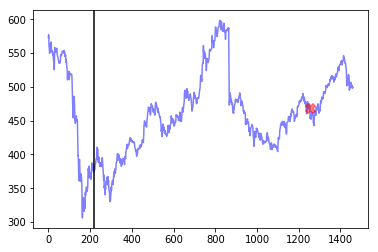

In [4]:
ad.plot_outliers([], true_outlier_indices)

# GLM

In [5]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

100%|██████████| 1460/1460 [00:00<00:00, 18317.33it/s]

Initial Mean 468.156598173516
Initial StdDev 85.23642935612166



100%|██████████| 1460/1460 [00:00<00:00, 20918.01it/s]

eta:  0.5
lambda:  0.99
MSE:  1400.5867982773163
Initial Mean 468.156598173516
Initial StdDev 85.23642935612166



100%|██████████| 1460/1460 [00:00<00:00, 23383.64it/s]

eta:  0.5
lambda:  0.999
MSE:  3514.7732284719864
Initial Mean 468.156598173516
Initial StdDev 85.23642935612166



100%|██████████| 1460/1460 [00:00<00:00, 23330.01it/s]

eta:  0.5
lambda:  0.9999
MSE:  3843.955404588634
Initial Mean 468.156598173516
Initial StdDev 85.23642935612166



100%|██████████| 1460/1460 [00:00<00:00, 22763.95it/s]

eta:  1
lambda:  0.99
MSE:  665.1990571268648
Initial Mean 468.156598173516
Initial StdDev 85.23642935612166



100%|██████████| 1460/1460 [00:00<00:00, 22136.73it/s]

eta:  1
lambda:  0.999
MSE:  2774.5907226878653
Initial Mean 468.156598173516
Initial StdDev 85.23642935612166


eta:  1
lambda:  0.9999
MSE:  3203.313816141451

best params:  eta 1 lambda 0.99


100%|██████████| 1460/1460 [00:00<00:00, 16745.56it/s]

Initial Mean 468.156598173516
Initial StdDev 85.23642935612166


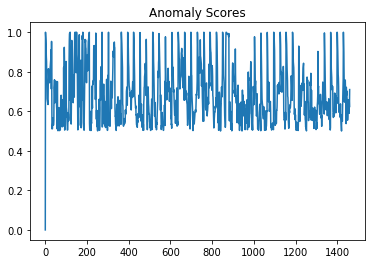

Time:  0.27936506271362305


['anomaly_scores/GLM/ibm-common-stock-closing-prices']

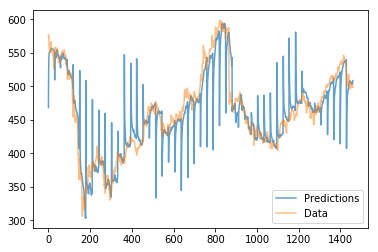

In [6]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=1, lambda_=0.99,plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# SARIMA: using autoarima


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 1509.832
 ARIMA(0,0,0) with non-zero mean : 1919.167
 ARIMA(1,0,0) with non-zero mean : 1516.209
 ARIMA(0,0,1) with non-zero mean : 1772.576
 ARIMA(0,0,0) with zero mean     : 1916.009
 ARIMA(1,0,2) with non-zero mean : 1507.122
 ARIMA(0,0,2) with non-zero mean : 1704.731
 ARIMA(1,0,1) with non-zero mean : 1505.564
 ARIMA(2,0,1) with non-zero mean : 1507.643
 ARIMA(2,0,0) with non-zero mean : 1504.379
 ARIMA(3,0,0) with non-zero mean : 1508.238
 ARIMA(3,0,1) with non-zero mean : 1509.821
 ARIMA(2,0,0) with zero mean     : 1503.666
 ARIMA(1,0,0) with zero mean     : 1514.606
 ARIMA(3,0,0) with zero mean     : 1507.533
 ARIMA(2,0,1) with zero mean     : 1506.899
 ARIMA(1,0,1) with zero mean     : 1504.779
 ARIMA(3,0,1) with zero mean     : 1509.154

 Now re-fitting the best model(s) without approximations...

 ARIMA(2,0,0) with zero mean     : 1506.381

 Best model: Regression with ARIMA(2,0,0

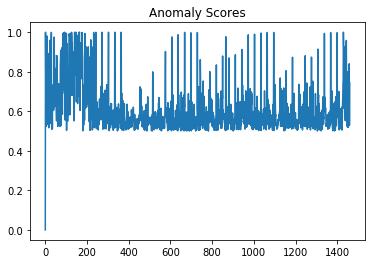

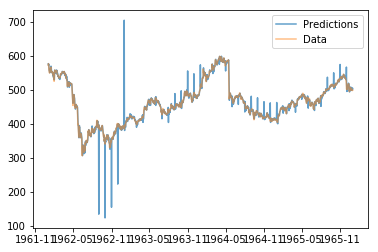

Time:  10.100842475891113


['anomaly_scores/SARIMA_auto/ibm-common-stock-closing-prices']

In [7]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

In [8]:
# optimization step

step_sizes = [100, 200]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for changepoint_prior_scale in changepoint_prior_scales:

        mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=changepoint_prior_scale,
                                  step_size=step_size,
                                  optimize=True)
        print("Step Size: ", step_size)
        print("Changepoint Prior Scale: ", changepoint_prior_scale)
        print("MSE: ",mse)

        key_str = "Step Size " + str(step_size) +" Changepoint Prior Scale" + str(changepoint_prior_scale)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.01
MSE:  816.917651201516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.05
MSE:  474.6380765776547


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.1
MSE:  295.3866900688394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.15
MSE:  265.6627130017633


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.2
MSE:  262.5185365992113


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.01
MSE:  816.917651201516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.05
MSE:  474.6380765776547


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.1
MSE:  295.3866900688394


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.15
MSE:  265.6627130017633
Step Size:  200
Changepoint Prior Scale:  0.2
MSE:  262.5185365992113

best params:  Step Size 100 Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


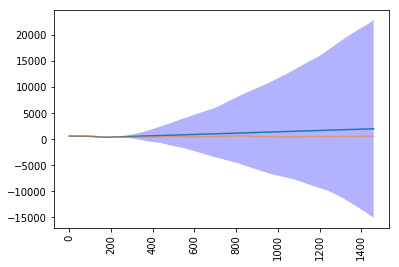

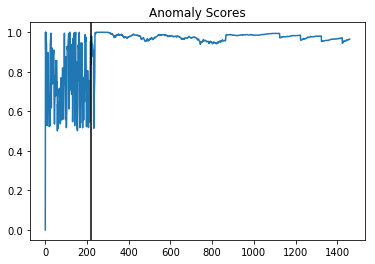

Time:  6.284790754318237


['anomaly_scores/Prophet/ibm-common-stock-closing-prices']

In [9]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

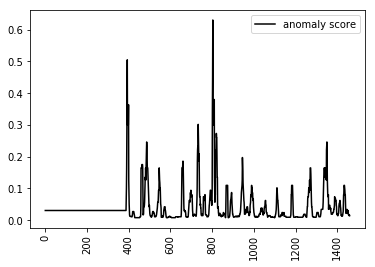

Time:  14.35


['anomaly_scores/HTM/ibm-common-stock-closing-prices']

In [10]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", 14.35)
output_dict = {"Anomaly Scores": anomaly_scores, "Time": 14.35}
joblib.dump(output_dict, save_path)

# windowed gaussian

In [11]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  8771.640050319838
Step size:  200
MSE:  8771.640050319838
Step size:  300
MSE:  8771.640050319838
Step size:  400
MSE:  8771.640050319838
Step size:  500
MSE:  8771.640050319838

best step size:  100


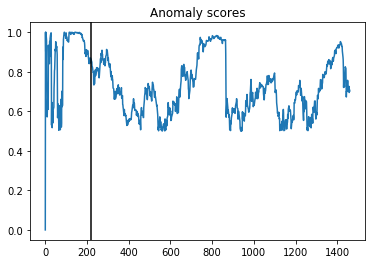

Time:  0.22719931602478027


['anomaly_scores/windowed_gaussian/ibm-common-stock-closing-prices']

In [12]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

In [13]:
# only need one window size

# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

In [14]:
# no twitter bc no seasonality
# no stl bc no seasonality
# no anomalous bc no seasonality